div_solenoidal max: 5.45428093541766e-13
variance:
solenoidal x,y,z: 12004.53547453025 13702.149732710639 14145.132360481466
compressive x,y,z: 7584.776902083831 7189.9374727396735 6267.474764262694


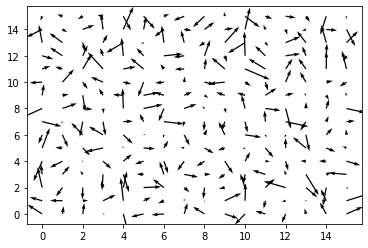

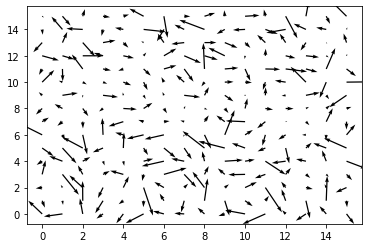

In [3]:
"""
Helmholtz-Hodge decomposition using fft
Xun Shi 18.04.2018
--------------------------------------
Given 3D velocity field, decompose to solenoidal and compressive parts

Note:
1. Only for uniform grid with dx = dy = dz. Extensions are easy to implement.

2. Helmholtz-Hodge decomposition performed with spectral method should only apply to relatively smooth fields, i.e. with
 little power on small scales

3. For even NX, NY, NZ, decomposed fields can be complex, with the imaginary part coming from the real part of the kmode
 at Nyquist frequency. In principle, when doing first derivatives, the Nyquist frequency kmode should be dropped so as n
ot to break symmetry. See e.g. footnote on page 4 of

http://math.mit.edu/~stevenj/fft-deriv.pdf

However, when the field is smooth enough, the imaginary part caused by the Nyquist frequency kmode should be negligible.

"""

import numpy as np
import matplotlib.pyplot as plt

Vf = np.fromfile('../helmholtz/v0_xyz_16_16_128.dat').reshape(3,16,16,128)

if Vf.shape[0]!=3: print('Not a 3D field in required form!')

NX, NY, NZ = Vf.shape[1:]

Vfx = Vf[0]
Vfy = Vf[1]
Vfz = Vf[2]

vx_f = np.fft.fftn(Vfx)
vy_f = np.fft.fftn(Vfy)
vz_f = np.fft.fftn(Vfz)
kx   = np.fft.fftfreq(NX).reshape(NX,1,1)
ky   = np.fft.fftfreq(NY).reshape(NY,1)
kz   = np.fft.fftfreq(NZ)
k2   = kx**2 + ky**2 + kz**2
k2[0,0,0] = 1. # to avoid inf. we do not care about the k=0 component

div_Vf_f = (vx_f * kx +  vy_f * ky + vz_f * kz) #* 1j
V_compressive_overk = div_Vf_f / k2
V_compressive_x = np.fft.ifftn(V_compressive_overk * kx) #[:,np.newaxis,np.newaxis])
V_compressive_y = np.fft.ifftn(V_compressive_overk * ky)
V_compressive_z = np.fft.ifftn(V_compressive_overk * kz)

V_solenoidal_x = Vfx - V_compressive_x
V_solenoidal_y = Vfy - V_compressive_y
V_solenoidal_z = Vfz - V_compressive_z

# check if the solenoidal part really divergence-free
divVs = np.fft.ifftn((np.fft.fftn(V_solenoidal_x) * kx + np.fft.fftn(V_solenoidal_y) * ky + np.fft.fftn(V_solenoidal_z)
* kz) * 1j * 2. * np.pi)

print('div_solenoidal max:', abs(divVs).max())

# check the power in solenoidal and compressive components
print('variance:')
print('solenoidal x,y,z:', V_solenoidal_x.var(), V_solenoidal_y.var(), V_solenoidal_z.var())
print('compressive x,y,z:', V_compressive_x.var(), V_compressive_y.var(), V_compressive_z.var())

# plot one slice of the decomposed field on X-Y plane
X, Y = np.meshgrid(range(NY), range(NX))
plt.figure()
plt.quiver(X, Y, V_solenoidal_x[:,:,0], V_solenoidal_y[:,:,0])
plt.figure()
plt.quiver(X, Y, V_compressive_x[:,:,0], V_compressive_y[:,:,0])
plt.ion()
plt.show()

